# Customer Segmentation using DBSCAN

## Objectives
1. Load and preprocess wholesale customer data.
2. Apply outlier treatment and remove highly correlated variables.
3. Determine the optimal `eps` value using a K-distance plot.
4. Evaluate clustering results using DBSCAN.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# 1. Load the dataset
df = pd.read_csv('ML470_S8_Wholesale Customers data_Practice.csv')

# 2. Select numerical columns (Excluding categorical columns like Channel and Region)
numeric_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
df_numeric = df[numeric_cols].copy()

# 3. Round numerical values to two decimals
df_numeric = df_numeric.round(2)

print("Initial Numerical Data:")
print(df_numeric.head())

Initial Numerical Data:
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185


In [2]:
# 4. Apply outlier treatment using IQR-based capping
def cap_outliers(df):
    df_capped = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, 
                                  np.where(df_capped[col] < lower_bound, lower_bound, df_capped[col]))
    return df_capped

df_capped = cap_outliers(df_numeric)
print("Data after Outlier Capping:")
print(df_capped.describe())

Data after Outlier Capping:
              Fresh          Milk      Grocery       Frozen  Detergents_Paper  \
count    440.000000    440.000000    440.00000   440.000000        440.000000   
mean   11357.568182   5048.592045   7236.37500  2507.085795       2392.616477   
std    10211.542235   4386.377073   6596.53308  2408.297738       2940.794090   
min        3.000000     55.000000      3.00000    25.000000          3.000000   
25%     3127.750000   1533.000000   2153.00000   742.250000        256.750000   
50%     8504.000000   3627.000000   4755.50000  1526.000000        816.500000   
75%    16933.750000   7190.250000  10655.75000  3554.250000       3922.000000   
max    37642.750000  15676.125000  23409.87500  7772.250000       9419.875000   

        Delicassen  
count   440.000000  
mean   1266.715341  
std    1083.069792  
min       3.000000  
25%     408.250000  
50%     965.500000  
75%    1820.250000  
max    3938.250000  


In [6]:
# 5. Remove highly correlated features
corr_matrix = df_capped.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print(upper)
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f"Dropping highly correlated features: {to_drop}")
df_final = df_capped.drop(columns=to_drop)

# 6. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final)

print(f"Preprocessed data shape: {X_scaled.shape}")

                  Fresh      Milk   Grocery    Frozen  Detergents_Paper  \
Fresh               NaN  0.037991  0.098357  0.355487          0.226033   
Milk                NaN       NaN  0.781205  0.037049          0.691217   
Grocery             NaN       NaN       NaN  0.137456          0.877444   
Frozen              NaN       NaN       NaN       NaN          0.239435   
Detergents_Paper    NaN       NaN       NaN       NaN               NaN   
Delicassen          NaN       NaN       NaN       NaN               NaN   

                  Delicassen  
Fresh               0.259404  
Milk                0.372097  
Grocery             0.290121  
Frozen              0.237178  
Detergents_Paper    0.161233  
Delicassen               NaN  
Dropping highly correlated features: ['Detergents_Paper']
Preprocessed data shape: (440, 5)


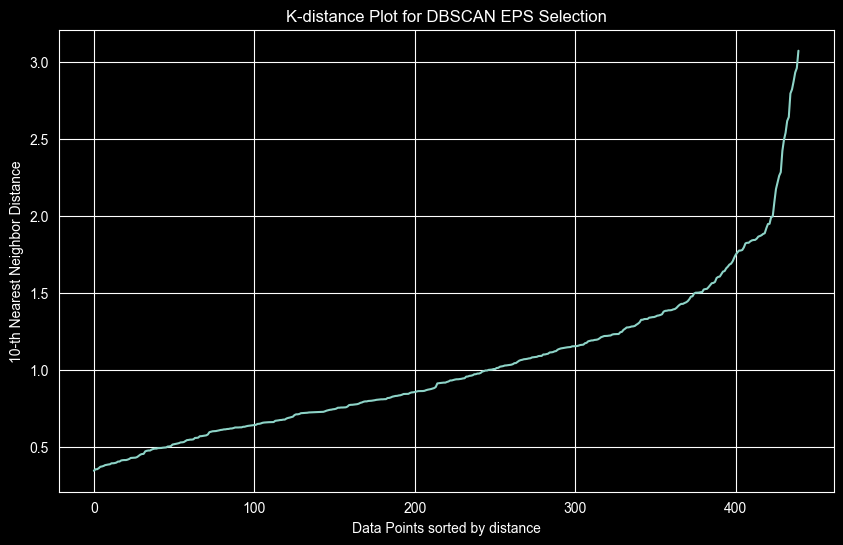

In [4]:
# 7. Generate K-distance plot to determine appropriate eps
min_samples = 2 * X_scaled.shape[1]  # Common heuristic
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Plot for DBSCAN EPS Selection')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

Number of clusters found: 1
Number of noise points: 199


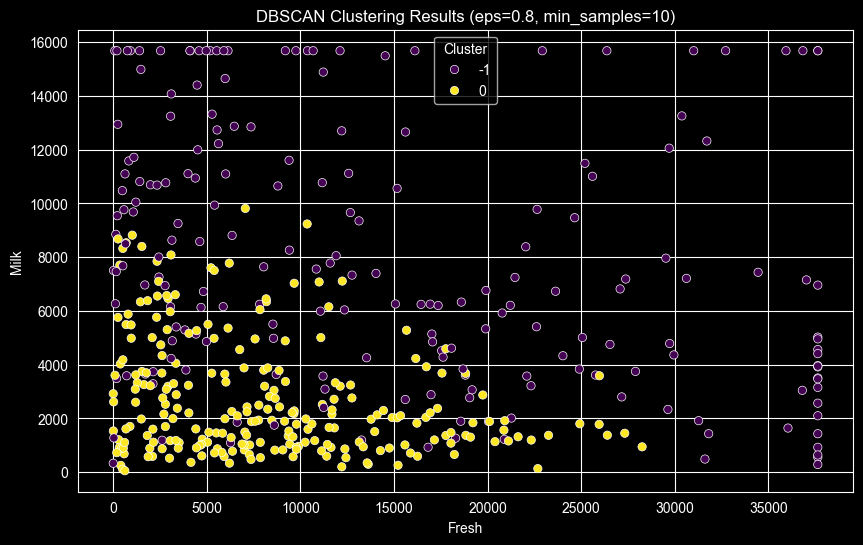

In [5]:
# 8. Apply DBSCAN and visualize outcomes
# Based on the k-distance plot, we select an eps where the elbow occurs
# For this dataset, usually around 0.5 - 1.0 depending on scaling
eps_val = 0.8 
dbscan = DBSCAN(eps=eps_val, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

df_final['Cluster'] = clusters

print(f"Number of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
print(f"Number of noise points: {list(clusters).count(-1)}")

# Visualization of clusters (using first two principal components or features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_final.iloc[:, 0], y=df_final.iloc[:, 1], hue=df_final['Cluster'], palette='viridis')
plt.title(f'DBSCAN Clustering Results (eps={eps_val}, min_samples={min_samples})')
plt.show()